In [65]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import time
import datetime as dt
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
import joblib
import copy


import utils


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
features = [1,2,3,4,5,6,7,8,9,0,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26]
labels = [1,2,3,4,5,6,7,8,9,0,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26]
dates = [1,2,3,4,5,6,7,8,9,0,11,12,13,14,15,16,17,18,19,20,21,22,23,255,266]

In [67]:
inp,lbl,dates = utils.split_timeseries(3,5-2,features,labels,dates)
print(inp)
print(lbl)
print(dates)

[[ 1  2  3]
 [ 2  3  4]
 [ 3  4  5]
 [ 4  5  6]
 [ 5  6  7]
 [ 6  7  8]
 [ 7  8  9]
 [ 8  9  0]
 [ 9  0 11]
 [ 0 11 12]
 [11 12 13]
 [12 13 14]
 [13 14 15]
 [14 15 16]
 [15 16 17]
 [16 17 18]
 [17 18 19]
 [18 19 20]
 [19 20 21]]
[ 7  8  9  0 11 12 13 14 15 16 17 18 19 20 21 22 23 25 26]
[  7   8   9   0  11  12  13  14  15  16  17  18  19  20  21  22  23 255
 266]


In [68]:
#train_batches,validation_batches,test_batches = utils.train_test_split(inp,lbl,dates,10,0.8,0)
#train_batches,validation_batches,test_batches = utils.train_test_split(inp,lbl,dates,inp.shape[0]-5,0.8,5)
train_batches,validation_batches,test_batches = utils.train_test_split(inp,lbl,dates,inp.shape[0],0.9,0.5,0)

In [69]:
print(train_batches[-1])
print("-------")
print(validation_batches[-1])
print('--------')
print(test_batches[-1])

(array([[ 1,  2,  3],
       [ 2,  3,  4],
       [ 3,  4,  5],
       [ 4,  5,  6],
       [ 5,  6,  7],
       [ 6,  7,  8],
       [ 7,  8,  9],
       [ 8,  9,  0],
       [ 9,  0, 11],
       [ 0, 11, 12],
       [11, 12, 13],
       [12, 13, 14],
       [13, 14, 15],
       [14, 15, 16],
       [15, 16, 17],
       [16, 17, 18],
       [17, 18, 19]]), array([ 7,  8,  9,  0, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]), array([ 7,  8,  9,  0, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]))
-------
(array([[18, 19, 20]]), array([25]), array([255]))
--------
(array([[19, 20, 21]]), array([26]), array([266]))


In [70]:
#input_data = './MSc Student Data 2021/data/v1/aluminium - month/aluminium_inputs.csv'
#target_data = './MSc Student Data 2021/data/v1/aluminium - month/aluminium_target.csv'

input_data = './MSc Student Data 2021/data/v1/copper - month/copper_inputs.csv'
target_data = './MSc Student Data 2021/data/v1/copper - month/copper_target.csv'

In [71]:
f = []
for (dirpath, dirnames, filenames) in os.walk('../MSc Student Data 2021/aluminium - month'):
    f.extend(filenames)
    print(f)
    break

In [72]:
input_df = pd.read_csv(input_data)
target_df = pd.read_csv(target_data)

In [73]:
dates = input_df['date'].values

In [74]:
target_df[['y']] = StandardScaler().fit_transform(target_df[['y']])

In [75]:
#target_df['log return'] = np.log(target_df['y']).diff()

In [76]:
input_df[input_df.columns[1:]] = StandardScaler().fit_transform(input_df[input_df.columns[1:]])

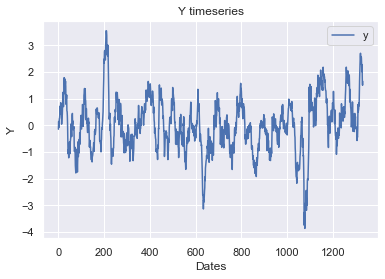

In [77]:
y = target_df['y'].values
index = [i+1 for i in range(len(y))]

plt.plot(index, y ,label = "y")
plt.xlabel('Dates')
plt.ylabel('Y')
plt.title('Y timeseries')
plt.legend()
plt.show()
print()

In [78]:
input_df.columns[1]

'cot_positions_0'

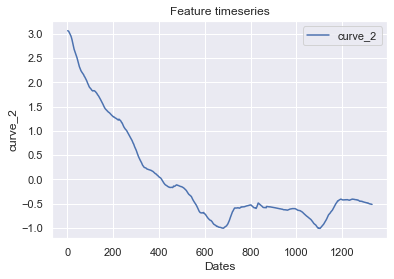

In [79]:
features = []
for col in input_df.columns:
    features.append(input_df[col].values)
    
index = [i+1 for i in range(len(y))]

#for i, col in enumerate(input_df.columns):
#if(i!=0):

i = 7

plt.plot(index, features[i] ,label = input_df.columns[i])
    
plt.xlabel('Dates')
plt.ylabel(input_df.columns[i])
plt.title('Feature timeseries')
plt.legend()
plt.show()
print()

In [80]:
def convert_log_return(labels):
    l = []
    for count, value in enumerate(labels):
        if(count!=len(labels)-1):
            
            if(labels[count] == 0):
                labels[count] += 0.00001
            if(labels[count + 1] == 0):
                l.append(np.log(0.00001))
            else:
                l.append(np.log((labels[count + 1])/(labels[count])))
    return l

In [81]:
inputs = np.array(features[1:]).transpose()
labels = np.array(y)

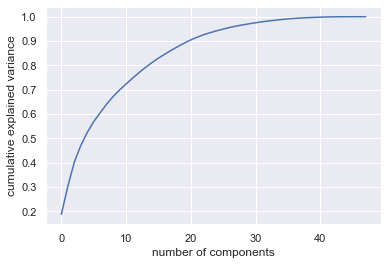

In [82]:
pca = PCA().fit(inputs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [83]:
pca = PCA(n_components=30)
pca.fit(inputs)
inputs_pca = pca.transform(inputs)
print("original shape:   ", inputs_pca.shape)
print("transformed shape:", inputs_pca.shape)

original shape:    (1330, 30)
transformed shape: (1330, 30)


In [84]:
inputs = inputs_pca

In [85]:
inp,lbl,dates = utils.split_timeseries(1,22-2,inputs,labels,dates)

#inp,lbl,dates = utils.split_timeseries(28,22-2,inputs,labels,dates)

print(inp.shape)
print(lbl.shape)

'''joblib.dump(inp, '../Vectors/aluminium_vectors')
joblib.dump(lbl, '../Vectors/aluminium_labels')
joblib.dump(dates, '../Vectors/aluminium_dates')'''

'''joblib.dump(inp, '../Vectors/copper_vectors')
joblib.dump(lbl, '../Vectors/copper_labels')
joblib.dump(dates, '../Vectors/copper_dates')'''


inp = np.reshape(inp, (inp.shape[0],inp.shape[1]*inp.shape[2]))
print(inp.shape)


(1309, 1, 30)
(1309,)
(1309, 30)


In [86]:
#train_batches,validation_batches,test_batches = utils.train_test_split(inp,lbl,dates,inp.shape[0]-22,0.8,22)
train_batches,validation_batches,test_batches = utils.train_test_split(inp,lbl,dates,100,0.9,0.5,0)
#train_batches,validation_batches,test_batches = utils.train_test_split(inp,lbl,dates,inp.shape[0],0.8,0)
#test_batches = validation_batches

In [87]:
print(len(train_batches))
print(len(test_batches))
train_data,train_labels,train_dates = train_batches[0]
test_data,test_labels,test_dates = test_batches[0]

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)
print(len(train_dates))
print(len(test_dates))

242
242
(90, 30)
(90,)
(5, 30)
(5,)
90
5


In [88]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())

        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

No improvement found during the last iterations, stopping optimization at epoch: 25


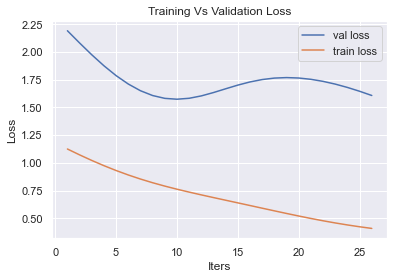

In [89]:
predictions = []

for i,train_batch in enumerate(train_batches):
    
    training_loss = []
    validation_loss = []
    
    print("Training batch " + str(i) + "/" + str(len(train_batches)))
    train_data,train_labels,train_dates = train_batch
    test_data,test_labels,test_dates = test_batches[i]
    val_data,val_labels,val_dates = validation_batches[i]
    print("Train Dates: " + train_dates[0] + " " + train_dates[-1])
    print("Val Dates: " + val_dates[0] + " " + val_dates[-1])
    print("Test Dates: " + test_dates[0] + " " + test_dates[-1])

    clear_output(wait=True)

    
    train_data = torch.from_numpy(train_data)
    train_labels = torch.from_numpy(train_labels)
    test_data = torch.from_numpy(test_data)
    test_labels = torch.from_numpy(test_labels)
    val_data = torch.from_numpy(val_data)
    val_labels = torch.from_numpy(val_labels)


    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_data, train_labels, likelihood)
    
    model.double()
    
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    training_iter = 150
    
    #for early stopping :
    best_cost=1000000 
    stop = False
    last_improvement=0
    require_improvement = 15
    
    best_model = None
    
    epoch = 0

    while epoch < training_iter and stop == False:
        
        # Find optimal model hyperparameters
        model.train()
        likelihood.train()
        
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_data)
        # Calc loss and backprop gradients
        loss = -mll(output, train_labels)
        loss.backward()
        
        '''print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))'''
        optimizer.step()
        training_loss.append(loss.item())

        
        # Get into evaluation (predictive posterior) mode
        model.eval()
        likelihood.eval()
        
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            ## Calculate the validation loss
            val_loss = -mll(model(val_data), val_labels)
            validation_loss.append(val_loss.item())
            
        ## Early Stopping Here
        #early stopping based on the validation set/ max_steps_without_decrease of the loss value : require_improvement
        avg_cost = val_loss.item()
        if avg_cost < best_cost:
            best_cost = avg_cost
            last_improvement = 0
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(best_model_state, 'GPModel.pt')
        else:
            last_improvement +=1
            
        if last_improvement > require_improvement:
            print("No improvement found during the last iterations, stopping optimization at epoch: " + str(epoch))
            # Break out from the loop.
            stop = True
            
        epoch += 1
      
    model = ExactGPModel(train_data, train_labels, likelihood)
    model.load_state_dict(torch.load('GPModel.pt'))
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_data))
        predictions.append(observed_pred)
        
    index = [i+1 for i in range(len(validation_loss))]
    plt.plot(index, validation_loss ,label = "val loss")
    plt.plot(index, training_loss, label = "train loss")
    plt.xlabel('Iters')
    plt.ylabel('Loss')
    plt.title('Training Vs Validation Loss')
    plt.legend()
    plt.show()

    
    
    #time.sleep(3)

In [90]:
### get the predictions
mean_preds = []
lower = []
upper = []
test_dates = []

mde_list = []
rmse_list = []

for i,pred in enumerate(predictions):
    
        _,labels,d = test_batches[i]
        test_dates.append(d)
        mean_preds.append(pred.mean.numpy())
        
        mde_list.append(utils.mean_directional_accuracy(labels,pred.mean.numpy()))
        rmse_list.append(utils.rmse(pred.mean.numpy(), labels))
        
        l, u = pred.confidence_region()
        lower.append(l.detach().numpy())
        upper.append(u.detach().numpy())
        
mean_preds = np.array(mean_preds).flatten()
lower = np.array(lower).flatten()
upper = np.array(upper).flatten()

In [91]:
flat_dates = [item for sublist in test_dates for item in sublist]

In [92]:
index = [i+1 for i in range(mean_preds.shape[0])]
val_split_num = [i+1 for i in range(len(mde_list))]

In [93]:
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in flat_dates]

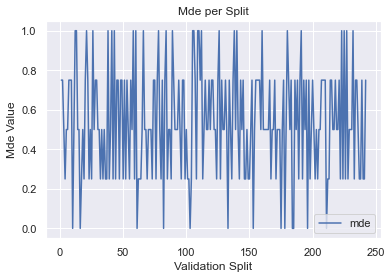

In [94]:
plt.plot(val_split_num, mde_list ,label = "mde")
plt.xlabel('Validation Split')
plt.ylabel('Mde Value')
plt.title('Mde per Split')
plt.legend()
plt.show()

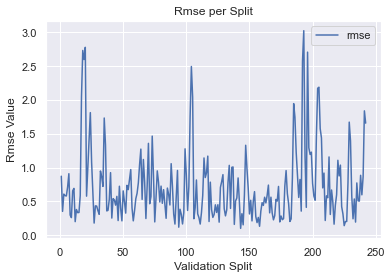

In [95]:
plt.plot(val_split_num, rmse_list ,label = "rmse")
plt.xlabel('Validation Split')
plt.ylabel('Rmse Value')
plt.title('Rmse per Split')
plt.legend()
plt.show()

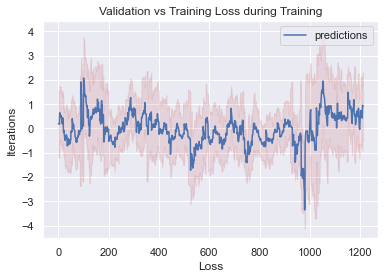

In [96]:
fig, ax = plt.subplots()
ax.plot(index,mean_preds,label = 'predictions')
ax.fill_between(index, lower, upper, color='r', alpha=.15)
plt.xlabel('Loss')
plt.ylabel('Iterations')
plt.title('Validation vs Training Loss during Training')
plt.legend()
plt.show()

In [97]:
test_labels = []
for i,test_batch in enumerate(test_batches):
    _,l,_ = test_batch
    test_labels.append(l)
test_labels = np.array(test_labels).flatten()

In [98]:
index = index[0:500]
mean_preds = mean_preds[0:500]
test_labels = test_labels[0:500]

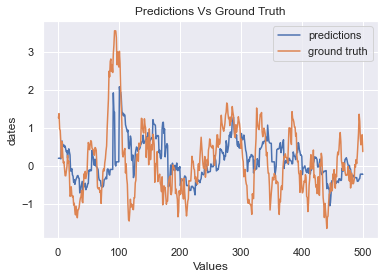

In [99]:
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator())
#plt.gcf().autofmt_xdate()
plt.plot(index, mean_preds ,label = "predictions")
plt.plot(index, test_labels, label = "ground truth")
plt.xlabel('Values')
plt.ylabel('dates')
plt.title('Predictions Vs Ground Truth')
plt.legend()
plt.show()

In [100]:
print("Mean Directional Accuracy: " + str(utils.mean_directional_accuracy(test_labels,mean_preds)))
print("Root Mean Squared Error : " + str(utils.rmse(mean_preds, test_labels)))
print("Mean Absolute Percentage Error: " + str(utils.mean_absolute_percentage_error(test_labels,mean_preds)))

Mean Directional Accuracy: 0.5390781563126252
Root Mean Squared Error : 0.8758709366735252
Mean Absolute Percentage Error: 207.11055016885842
